In [1]:
from pydub import AudioSegment

from data_processing import gen_clip, overlay_noise

clip = gen_clip(AudioSegment.from_file('parsed_files/raw_clips/government_9302.wav'))
noise = AudioSegment.from_file('audio/outside_rural/snipped119_start_240_end_250.wav')
noisy_clip = overlay_noise(2.0, clip, noise)
noisy_clip

c:\Users\nwong\Documents\nick-repo\.conda\Lib\site-packages\pycochleagram-0.1-py3.11.egg\pycochleagram\erbfilter.py:8: RuntimeWarning: pycochleagram using non-interactive Agg matplotlib backend
  from pycochleagram import utils


In [2]:
from data_processing import audio_to_cgram
from pycochleagram.cochleagram import apply_envelope_nonlinearity, human_cochleagram
import numpy as np

cochleagram = audio_to_cgram(noisy_clip)

arr = np.array(noisy_clip.get_array_of_samples())
cgram = human_cochleagram(arr, 16_000, 50, 30, 7860, 6, downsample=200).astype(np.float32)

cochleagram.shape, cgram.shape

c:\Users\nwong\Documents\nick-repo\.conda\Lib\site-packages\pycochleagram-0.1-py3.11.egg\pycochleagram\cochleagram.py:135: RuntimeWarning: divide by zero encountered in log10
  freqs_to_plot = np.log10(freqs)


((211, 400), (317, 400))

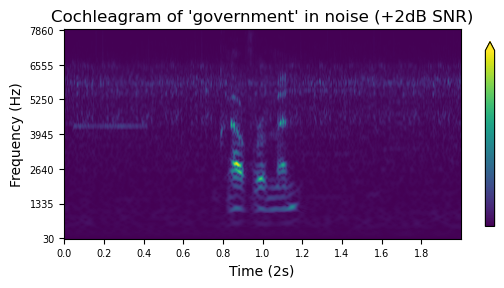

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

# cochleagram = np.load('parsed_files/music/between_172.npy')

fig, ax = plt.subplots()

dims = cochleagram.shape
nyticks = 6
nxticks = 10

im = ax.imshow(cochleagram, origin='lower')
fig.colorbar(im, ticks=[], shrink=0.5, extend='max')
ax.set_title("Cochleagram of 'government' in noise (+2dB SNR)")
ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('Time (2s)')
# plt.tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)
ax.tick_params(labelsize=7)
ax.set_yticks(np.arange(0, dims[0], dims[0] // nyticks), labels=np.linspace(30, 7860, nyticks+1, dtype=int))
ax.set_xticks(np.arange(0, dims[1], dims[1] // nxticks), labels=np.round(np.linspace(0, 2, nxticks, endpoint=False), 1))
fig.savefig('cochleagram.svg')
plt.show()

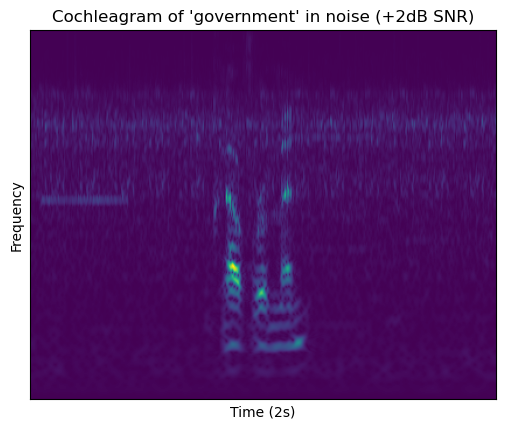

In [4]:

plt.imshow(cgram, origin='lower')
plt.title("Cochleagram of 'government' in noise (+2dB SNR)")
plt.ylabel('Frequency')
plt.xlabel('Time (2s)')
plt.tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)
plt.show()

In [5]:
from data_processing import aa_cgram

cgrams = [aa_cgram(cochleagram), aa_cgram(cgram)]

In [6]:
for i in range(len(cgrams)):
    cgrams[i] = cgrams[i] / np.max(cgrams[i])

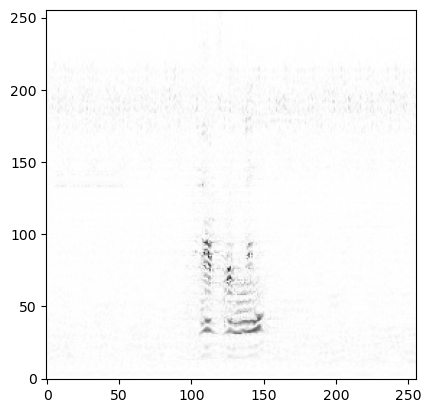

In [7]:
diff = np.abs(cgrams[0] - cgrams[1])
plt.imshow(diff, cmap='Greys', origin='lower')
plt.show()

In [8]:
from scipy import signal

In [82]:
fs = 7860 * 2
crit_freq = 2000

b, a = signal.butter(1, crit_freq, 'low', fs=fs)
w, h = signal.freqz(b, a, 256, whole=False, fs=fs)

In [83]:
def lessen_filter(h, scale = 2):
    h = 20 * np.log(abs(h))
    h *= .7
    h = 10 ** (h / 20)
    h = (h + (scale - 1)) / scale
    return h

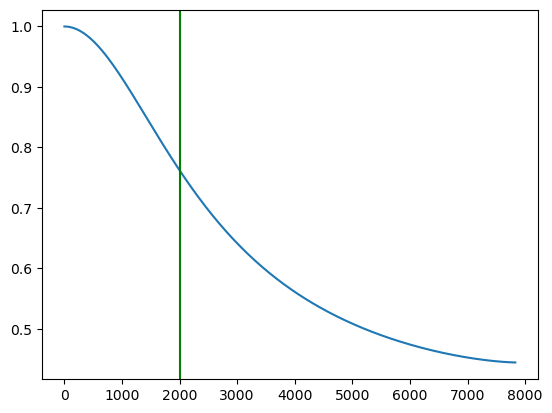

In [88]:
# plt.semilogx(w, abs(h))
# plt.plot(w, 20 * np.log(abs(h)))
# plt.plot(w, h)
plt.plot(w, lessen_filter(h, scale=1.8))
plt.axvline(crit_freq, color='green') # cutoff frequency

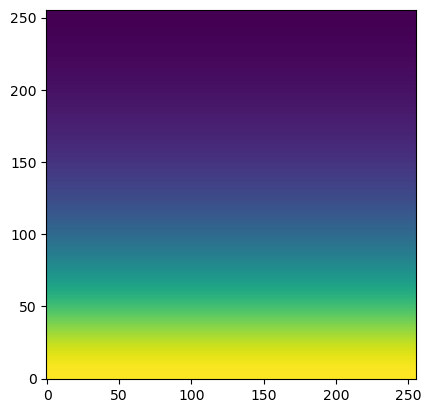

In [106]:
hh = lessen_filter(h, scale=1.5)
lp_filter = np.repeat([hh], 256, axis=0).transpose()
plt.imshow(lp_filter, origin='lower')

In [158]:
def plot_im(ax, title, data, vmin, vmax, cmap='magma', nxticks=4, nyticks=4):
    ax.set_title(title, fontsize=10)
    ax.imshow(data, origin='lower', vmin=vmin, vmax=vmax, cmap=cmap)
    dims = data.shape
    ax.set_yticks(np.linspace(0, dims[0], nyticks, dtype=int), labels=np.linspace(30, 7860, nyticks, dtype=int))
    ax.set_xticks(np.linspace(0, dims[1], nxticks, dtype=int), labels=np.round(np.linspace(0, 2, nxticks, endpoint=True), 1))
    ax.set_ylabel('Frequency (Hz)')
    ax.set_xlabel('Time (s)')

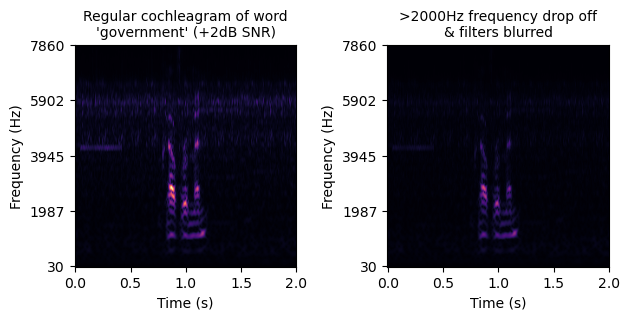

In [165]:
fig, ax = plt.subplots(1, 2)
vmin, vmax = np.min(cgrams[0]), np.max(cgrams[0])
cmap = 'magma'
# ax[0].set_title("Regular cochleagram of\n'government' (+2dB SNR)", fontsize=10)
# ax[0].imshow(cgrams[0], origin='lower', vmax=vmax, cmap=cmap)
nxticks = 5
nyticks = 5
plot_im(ax[0], "Regular cochleagram of word\n'government' (+2dB SNR)", cgrams[0], vmin, vmax, nxticks=nxticks, nyticks=nyticks)
plot_im(ax[1], ">2000Hz frequency drop off\n& filters blurred", cgrams[1] * lp_filter, vmin, vmax, nxticks=nxticks, nyticks=nyticks)
fig.tight_layout()
fig.savefig('compare_cochleagrams.svg')
plt.show()

In [1]:
import pandas as pd

df = pd.read_pickle('training_results.pkl')
df

,epoch,train_loss,validation_loss,train_accuracy,validation_accuracy
0,0,5.515068,5.414923,0.137340,"{'babble': 0.1328162291169451, 'music': 0.0014..."
1,1,4.178574,4.009605,0.214304,"{'babble': 0.20757756563245824, 'music': 0.001..."
2,2,3.740087,3.542441,0.284142,"{'babble': 0.27118138424821003, 'music': 0.001..."
3,3,3.409033,3.194486,0.330861,"{'babble': 0.3130071599045346, 'music': 0.0017..."
4,4,3.185908,2.954035,0.362287,"{'babble': 0.34051312649164683, 'music': 0.001..."
5,5,3.032766,2.783490,0.383331,"{'babble': 0.3578162291169451, 'music': 0.0017..."
6,6,2.906853,2.647481,0.402789,"{'babble': 0.37249403341288784, 'music': 0.001..."
7,7,2.803617,2.530985,0.420726,"{'babble': 0.38550119331742244, 'music': 0.001..."
8,8,2.689548,2.409454,0.438988,"{'babble': 0.40155131264916466, 'music': 0.001..."
9,9,2.584838,2.297698,0.460713,"{'babble': 0.4202267303102626, 'music': 0.0016..."


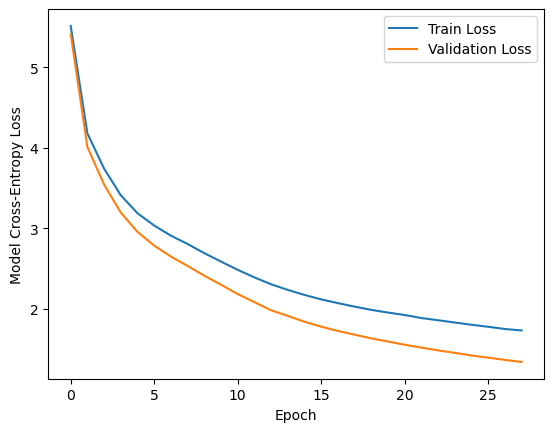

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_ylabel('Model Cross-Entropy Loss')
ax.set_xlabel('Epoch')
ax.plot(df['epoch'], df['train_loss'], label='Train Loss')
ax.plot(df['epoch'], df['validation_loss'], label='Validation Loss')
ax.legend()
fig.savefig('train_graph.svg')
plt.show()

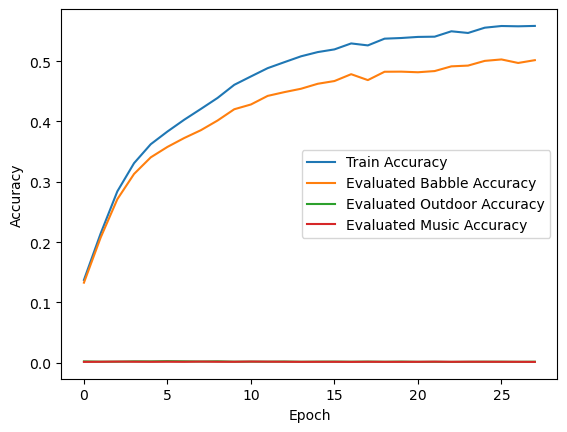

In [6]:
noise_conds = ['babble', 'outdoor', 'music']
accs = { n:[] for n in noise_conds }

for a in df['validation_accuracy']:
    [accs[n].append(a[n]) for n in noise_conds]

fig, ax = plt.subplots()
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.plot(df['epoch'], df['train_accuracy'], label='Train Accuracy')
for n in noise_conds:
    ax.plot(df['epoch'], accs[n], label=f'Evaluated {n.capitalize()} Accuracy')
ax.legend()
plt.show()